In [1]:
from SALib.sample import saltelli
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import lzma
import sys
import os

from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
os.chdir("../")
import cpt

# Saltelli Sampling

In [3]:
# problem definition
PROBLEM = {
    "num_vars" : 6,
    "names"    : ["theta",
                  "gain_right",
                  "saving_prop",
                  "prob_left",
                  "alpha",
                  "assistance"],
    "bounds"   : [[0.01, 0.20],
                  [1.70, 8.00],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [2.00, 12.0],
                  [0.05, 0.30]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X_debt = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)


# problem definition
PROBLEM = {
    "num_vars" : 5,
    "names"    : ["theta",
                  "gain_right",
                  "saving_prop",
                  "prob_left",
                  "alpha"],
    "bounds"   : [[0.01, 0.20],
                  [1.70, 8.00],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [2.00, 12.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X_no_debt = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

/var/folders/bj/4q98hxqx4vq6wwm8qqllvxmr0000gn/T/ipykernel_10433/872814574.py:20: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_debt = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)
/var/folders/bj/4q98hxqx4vq6wwm8qqllvxmr0000gn/T/ipykernel_10433/872814574.py:40: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_no_debt = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)


In [4]:
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    mean = np.mean(x) or 1
    rmad = mad/mean
    g = 0.5 * rmad
    return g

# Compute gini coefficients and proportion of agents richer at end of runs

In [5]:
def get_phase_plot_data(reps, params, folder_path, setup, num_agents=1225):

    GINIS = np.zeros((reps, params))
    PROP_RICHER = np.zeros((reps, params))

    for f in os.listdir(folder_pather_path):
        if f.endswith("lzma"):
            data = pickle.load(lzma.open(f"{folder_path}/{f}"))
            seed = int(f.split("_")[0])
            g = np.zeros(params)
            prop = np.zeros(params)
            for i,row in tqdm(enumerate(data)):
                r = row.T
                g[i] = gini(r[-1])
                prop[i] = np.sum(r[-1]>r[0]) / num_agents
            GINIS[seed] = g
            PROP_RICHER[seed] = prop

    with open(f"phase_plots_{setup}.pickle", "wb") as f:
        pickle.dump({"gini":GINIS, "prop_richer":PROP_RICHER}, f)

In [6]:
def get_phase_plot_data_communities(reps, params, setup):
    GINIS = np.zeros((reps, params))
    PROP_RICHER = np.zeros((reps, params))

    for seed_folder in os.listdir("DATA/nodebt/"):
        seed = int(seed_folder.split("_")[-1])
        files = os.listdir(f"DATA/nodebt/{seed_folder}")
        for f in tqdm(files):
            param_idx = int(f.split("_")[1]) - 1
            data = pickle.load(lzma.open(f"DATA/nodebt/{seed_folder}/{f}"))
            alpha_val = data["params"][4]

            # retrieve communities from graph
            with open(f"sda_graphs/{seed}_{alpha_val}.pickle", "rb") as f:
                communities, _, _, _ = pickle.load(f)
            NC = len(communities)

            # compute average community wealth trajectories
            data_W = data["W"]
            COMMUNITY_W = np.zeros((101, NC))
            for i,c in enumerate(communities):
                mean_comm_w = np.mean(data_W[:, np.array(list(c))], axis=1)
                COMMUNITY_W[:,i] = mean_comm_w

            # insert gini and prop richer values
            GINIS[seed][param_idx] = gini(COMMUNITY_W[-1])
            PROP_RICHER[seed][param_idx] = np.sum(COMMUNITY_W[-1]>COMMUNITY_W[0]) / NC
    
    with open(f"phase_plots_{setup}_communities.pickle", "wb") as f:
        pickle.dump({"gini":GINIS, "prop_richer":PROP_RICHER}, f)

In [98]:
get_phase_plot_data_communities(20, 7168, "nodebt")

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

  0%|          | 0/7168 [00:00<?, ?it/s]

# Plotting (micro)

In [6]:
with open("phase_plots_no_debt.pickle", "rb") as f:
    data = pickle.load(f)
GINIS = data["gini"]
PROP_RICHER = data["prop_richer"]

In [7]:
param_names = ["theta", "gain_right", "saving_prop", "prob_left", "alpha"]

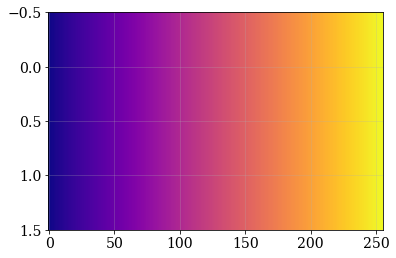

In [111]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1,1)
im = ax.imshow(gradient, aspect='auto', cmap="plasma")

In [9]:
with open("phase_plot_models.pickle", 'rb') as f:
    MODELS = pickle.load(f)

Finished subplot #1.
Finished subplot #2.
Finished subplot #3.
Finished subplot #4.
Finished subplot #5.
Finished subplot #6.
Finished subplot #7.
Finished subplot #8.
Finished subplot #9.
Finished subplot #10.


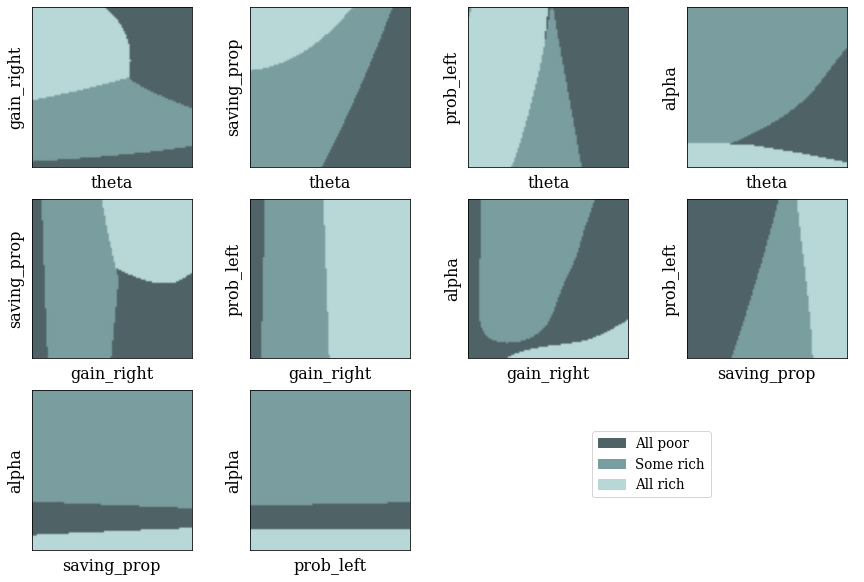

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))

try:
    with open("phase_plot_models.pickle", 'rb') as f:
        MODELS = pickle.load(f)
except: 
    MODELS = {}

colorsList = [("#4f6367"),("#7a9e9f"),("#b8d8d8")]
labels = {0:'All poor',1:'Some rich', 2:'All rich'}
CustomCmap = matplotlib.colors.ListedColormap(colorsList)
patches = [mpatches.Patch(color=colorsList[i],label=labels[i]) for i in range(len(colorsList))]

subplot_idx = 0

for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        X = []
        y = []
        for row in PROP_RICHER:
            idx = np.where((row >= 0) & (row <= 1))[0]
            X.append(np.column_stack([X_no_debt[idx,i], X_no_debt[idx,j]]))
            y.append(row[idx])
        X = np.concatenate(X)
        y = np.concatenate(y)
        
        # convert y to class labels
        y = np.where(y==1, 2, y)
        y = np.where((0<y)&(y<2), 1, y)
        
        # train model
        k = (param_names[i], param_names[j])
        if k in MODELS:
            svc = MODELS[k]
        else:
            svc = SVC(class_weight="balanced", C=0.1).fit(X, y)
            MODELS[(param_names[i], param_names[j])] = svc
        
        # create plot
        num_points = 100
        xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), num_points), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num_points))
        Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axs[int(subplot_idx/4)][int(subplot_idx%4)].imshow(Z, cmap=CustomCmap, interpolation="gaussian", 
                                                           origin="lower", interpolation_stage="rgba")
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xlabel(param_names[i])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_ylabel(param_names[j])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_yticks([])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xticks([])
        if subplot_idx == 9:
            axs[int(subplot_idx/4)][int(subplot_idx%4)].legend(handles=patches, 
                                                               bbox_to_anchor = (-0.23, -0.7, 1, 1),
                                                               bbox_transform = plt.gcf().transFigure)
        subplot_idx += 1
        print(f"Finished subplot #{subplot_idx}.")

# with open("phase_plot_models.pickle", "wb") as f:
#     pickle.dump(MODELS, f)

axs[2,2].axis('off')
axs[2,3].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.savefig("phase_plot_fig.pdf", bbox_inches="tight")
plt.show()

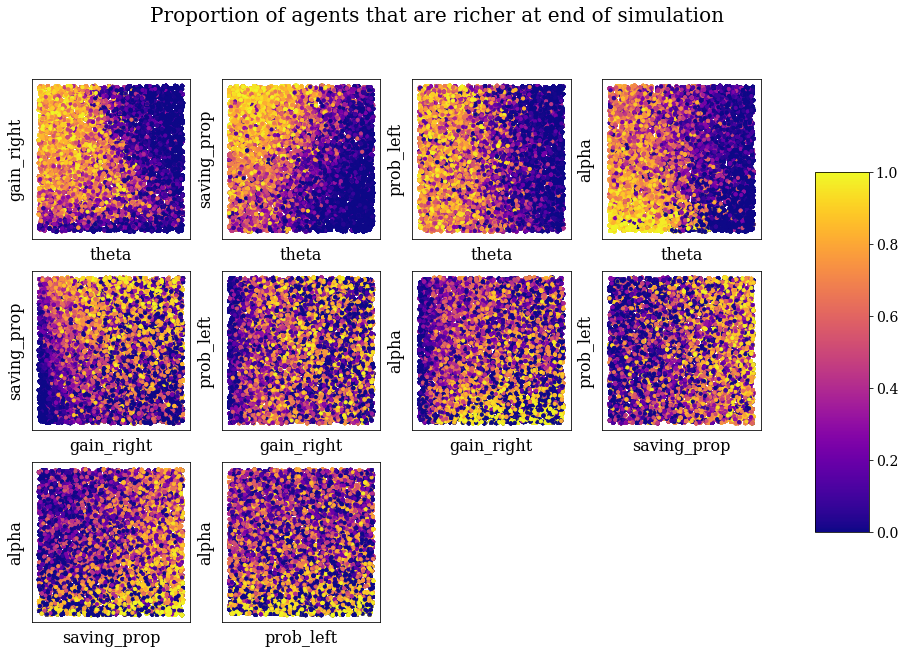

In [71]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))

subplot_idx = 0

for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        for row in PROP_RICHER:
            idx = np.where((row >= 0) & (row <= 1))[0]
            axs[int(subplot_idx/4)][int(subplot_idx%4)].scatter(X_no_debt[idx,i], X_no_debt[idx,j], 
                                              s=10, c=row[idx], cmap="plasma")
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xlabel(param_names[i])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_ylabel(param_names[j])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_yticks([])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xticks([])
            
        subplot_idx += 1

plt.suptitle("Proportion of agents that are richer at end of simulation", fontsize=20)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])

fig.colorbar(im, cax=cbar_ax)
# fig.tight_layout()
axs[2,2].axis('off')
axs[2,3].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.show()

In [114]:
# fig, axs = plt.subplots(3, 4, figsize=(15,10))

# subplot_idx = 0

# for i in range(len(param_names)):
#     for j in range(i+1, len(param_names)):
#         for row in GINIS:
#             idx = np.where((row >= 0) & (row <= 1))[0]
#             axs[int(subplot_idx/4)][int(subplot_idx%4)].scatter(X_no_debt[idx,i], X_no_debt[idx,j], 
#                                               s=10, c=row[idx], cmap="plasma")
#             axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xlabel(param_names[i])
#             axs[int(subplot_idx/4)][int(subplot_idx%4)].set_ylabel(param_names[j])
#             axs[int(subplot_idx/4)][int(subplot_idx%4)].set_yticks([])
#             axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xticks([])
            
#         subplot_idx += 1

# plt.suptitle("Gini Coefficients", fontsize=20)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])

# fig.colorbar(im, cax=cbar_ax)
# # fig.tight_layout()
# axs[2,2].axis('off')
# axs[2,3].axis('off')
# fig.patch.set_facecolor('xkcd:white')
# plt.show()

# Plotting (meso community)

In [8]:
with open("phase_plots_nodebt_communities.pickle", "rb") as f:
    data = pickle.load(f)
GINIS = data["gini"]
PROP_RICHER = data["prop_richer"]
param_names = ["theta", "gain_right", "saving_prop", "prob_left", "alpha"]

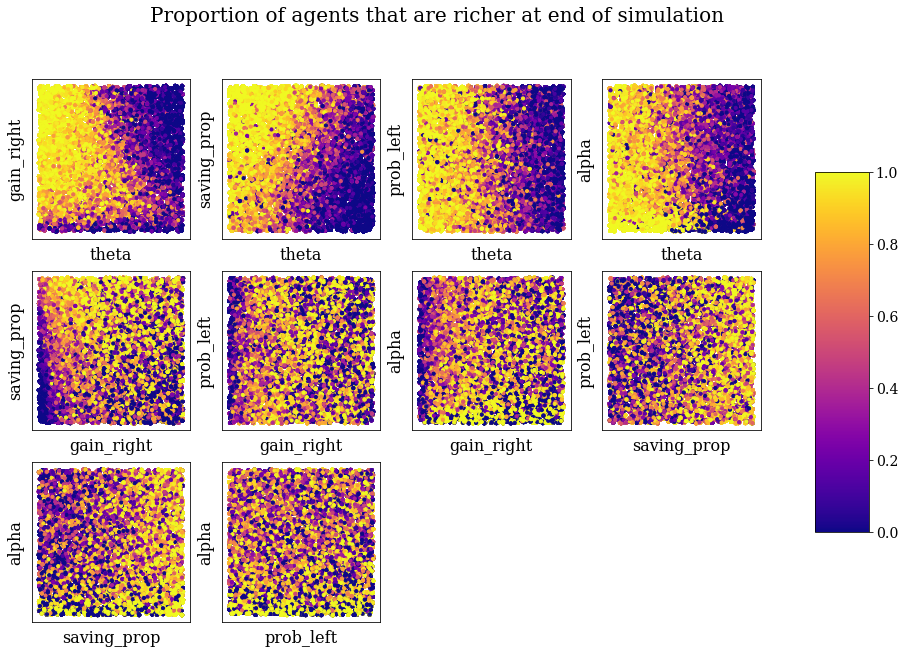

In [116]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))

subplot_idx = 0

for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        for row in PROP_RICHER:
            idx = np.where((row >= 0) & (row <= 1))[0]
            axs[int(subplot_idx/4)][int(subplot_idx%4)].scatter(X_no_debt[idx,i], X_no_debt[idx,j], 
                                              s=10, c=row[idx], cmap="plasma")
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xlabel(param_names[i])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_ylabel(param_names[j])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_yticks([])
            axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xticks([])
            
        subplot_idx += 1

plt.suptitle("Proportion of agents that are richer at end of simulation", fontsize=20)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])

fig.colorbar(im, cax=cbar_ax)
axs[2,2].axis('off')
axs[2,3].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.show()

Finished subplot #1 / 10
Finished subplot #2 / 10
Finished subplot #3 / 10
Finished subplot #4 / 10
Finished subplot #5 / 10
Finished subplot #6 / 10
Finished subplot #7 / 10
Finished subplot #8 / 10
Finished subplot #9 / 10
Finished subplot #10 / 10


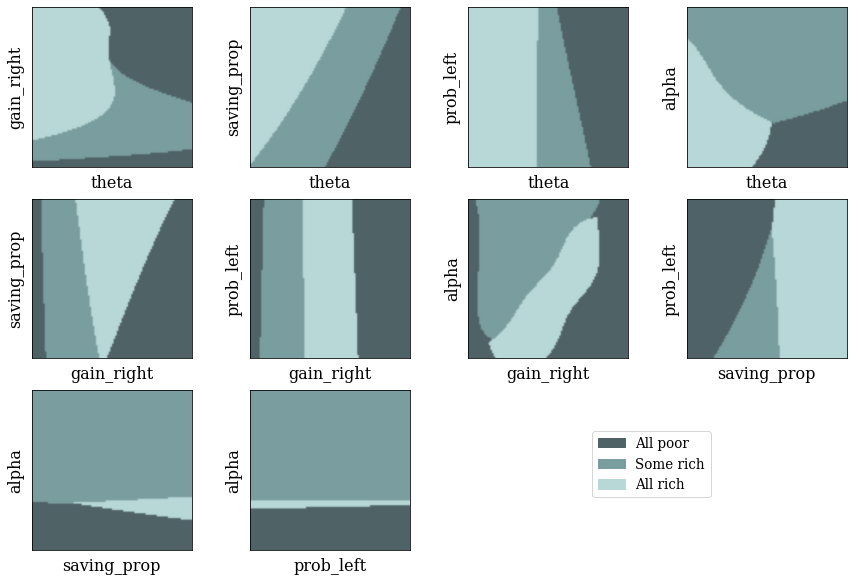

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(15,10))

try:
    with open("notebooks/phase_plot_models_communities.pickle", 'rb') as f:
        MODELS = pickle.load(f)
except: 
    MODELS = {}

colorsList = [("#4f6367"),("#7a9e9f"),("#b8d8d8")]
labels = {0:'All poor',1:'Some rich', 2:'All rich'}
CustomCmap = matplotlib.colors.ListedColormap(colorsList)
patches = [mpatches.Patch(color=colorsList[i],label=labels[i]) for i in range(len(colorsList))]

subplot_idx = 0

for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        X = []
        y = []
        for row in PROP_RICHER:
            idx = np.where((row >= 0) & (row <= 1))[0]
            X.append(np.column_stack([X_no_debt[idx,i], X_no_debt[idx,j]]))
            y.append(row[idx])
        X = np.concatenate(X)
        y = np.concatenate(y)
        
        # convert y to class labels
        y = np.where(y==1, 2, y)
        y = np.where((0<y)&(y<2), 1, y)
        
        # train model
        k = (param_names[i], param_names[j])
        if k in MODELS:
            svc = MODELS[k]
        else:
            svc = SVC(class_weight="balanced", C=0.1).fit(X, y)
            MODELS[(param_names[i], param_names[j])] = svc
        
        # create plot
        num_points = 100
        xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), num_points), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num_points))
        Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axs[int(subplot_idx/4)][int(subplot_idx%4)].imshow(Z, cmap=CustomCmap, interpolation="gaussian", 
                                                           origin="lower", interpolation_stage="rgba")
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xlabel(param_names[i])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_ylabel(param_names[j])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_yticks([])
        axs[int(subplot_idx/4)][int(subplot_idx%4)].set_xticks([])
        if subplot_idx == 9:
            axs[int(subplot_idx/4)][int(subplot_idx%4)].legend(handles=patches, 
                                                               bbox_to_anchor = (-0.23, -0.7, 1, 1),
                                                               bbox_transform = plt.gcf().transFigure)
        subplot_idx += 1
        print(f"Finished subplot #{subplot_idx} / 10")

with open("notebooks/phase_plot_models_communities.pickle", "wb") as f:
    pickle.dump(MODELS, f)

axs[2,2].axis('off')
axs[2,3].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.savefig("notebooks/phase_plot_communities_fig.pdf", bbox_inches="tight")
plt.show()